# NMR-EsPy Example: J-resolved estimation
In this example, I will go through some of the most useful features of the `Estimator2DJ` class for the consideration of data deived from J-resolved (2DJ) experiments. We will be using a simulated ¹H 2DJ spectrum of sucrose for this example. The data was simulated using [Spinach](https://spindynamics.org/wiki/index.php?title=Main_Page). You can create your own `Estimator2DJ` instances with SPinach-simulated data using the `new_spinach` classmethod, provided you have configured Spinach and the MATLAB engine for Python.

For this example, all the data has been pre-simulated. The primary reason for this is that it is difficult to run Jupyter notebooks on multiple cores, making Spinach simulations slower and more memory intensive.


If you don't, you can use my far less impressive package [nmr_sims](https://foroozandehgroup.github.io/nmr_sims/content/) instead, which is automatically installed with `pip install nmrespy`.

## What you'll need
* NMR-EsPy installed: `pip install nmrespy`
* [MATLAB Engine for Python](https://uk.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)
* [Spinach](https://spindynamics.org/wiki/index.php?title=Main_Page), both downloaded and configured to be run by MATLAB.

If you do not have MATLAB and/or Spinach, fear not. I have pre-simulated the data too so you can still follow along. You will have to set `i_can_run_spinach = False`.

## Pre-requisites
We will start by importing the pre-specified isotropic chemical shifts and scalar couplings, contained in the files `sucrose_shifts.pkl` and `sucrose_couplings.pkl`, respectively.

Note that if you want to specify your own spin systems, `shifts` and `couplings` need be of the following forms:

* `shifts`: A list of floats, with each value specifying the isotropic chemical shift in ppm.
* `couplings` A list of 3-element tuples, with each tuple of the form `(i1: int, i2: int, x: float)`. `i1` and       `i2` are the spins involved in the coupling (counting starts at 1...), and `x` is their scalar coupling in Hz.

In [1]:
%matplotlib inline
i_can_run_spinach = False

In [2]:
import pickle
with open("shifts.pkl", "rb") as fh:
    shifts = pickle.load(fh)
with open("couplings.pkl", "rb") as fh:
    couplings = pickle.load(fh)

print("----- SHIFTS -----")
print("\n".join([f"{i:<5}{shift:.3f}ppm" for i, shift in enumerate(shifts, start=1)]))
print("\n----- COUPLINGS -----")
print("\n".join([f"{i1:<3}- {i2:<5}{x:.3f}Hz" for i1, i2, x in couplings]))

----- SHIFTS -----
1    6.005ppm
2    3.510ppm
3    3.934ppm
4    3.423ppm
5    4.554ppm
6    3.891ppm
7    4.287ppm
8    3.332ppm
9    1.908ppm
10   1.555ppm
11   0.644ppm
12   4.042ppm
13   4.517ppm
14   3.889ppm
15   4.635ppm
16   4.160ppm
17   4.021ppm
18   4.408ppm
19   0.311ppm
20   1.334ppm
21   0.893ppm
22   0.150ppm

----- COUPLINGS -----
1  - 2    2.285Hz
2  - 3    4.657Hz
2  - 8    4.828Hz
3  - 4    4.326Hz
4  - 5    4.851Hz
5  - 6    5.440Hz
5  - 7    2.288Hz
6  - 7    -6.210Hz
7  - 11   7.256Hz
12 - 13   -4.005Hz
12 - 19   1.460Hz
14 - 15   4.253Hz
15 - 16   4.448Hz
15 - 21   3.221Hz
16 - 18   4.733Hz
17 - 18   -4.182Hz
18 - 22   1.350Hz


## Setting up the estimator
To set up an estiamtor with data synthesised using Spinach, you can use the `Estimator2DJ.new_spinach` classmethod.

If you cannot run Spinach, we can still set up an estimator by calling it's dunder init method with the arguments `fid` and `expinfo`. `fid` is pretty self-explanatory. `expinfo` is a class which specifies information about the experiment setup of relevance to NMR-EsPy (sweep width, transmitter offset, etc.).

We will assume a 300MHz magnet, set the transmitter offset at 1000Hz, the sweep widths in F1 and F2 as 40Hz and 2200Hz respectively, and the number of samples in T1 and T2 as 64 and 4096 respectively.

In [3]:
import nmrespy as ne

if i_can_run_spinach:
    estimator = ne.Estimator2DJ.new_spinach(
        shifts,
        (64, 4096),
        (40., 2200.),
        1000.,
        couplings = couplings,
        field = 300.,
        field_unit = "MHz",
    )
    
else:
    with open("fid.pkl", "rb") as fh:
        fid = pickle.load(fh)
    with open("expinfo.pkl", "rb") as fh:
        expinfo = pickle.load(fh)
    estimator = ne.Estimator2DJ(fid, expinfo)

## Running the estimation routine

We will now estimate the entire signal by generating filtered "sub-signals" in the direct dimension, and estimate each of these in turn. For the best results, it is necessary to specifiy region bounds that do not coincide with peaks in the direct-dimension spectrum, as this will lead to sub-signals which do not satify the underlying assumptions about the signal's structure which NMR-EsPy relies on.

In [4]:
regions = (                                                                             
    (6.08, 5.91),                                                                       
    (4.72, 4.46),                                                                       
    (4.46, 4.22),                                                                       
    (4.22, 4.1),                                                                        
    (4.09, 3.98),                                                                       
    (3.98, 3.83),                                                                       
    (3.58, 3.28),                                                                       
    (2.08, 1.16),                                                                       
    (1.05, 0.0),                                                                        
)      
n_regions = len(regions)
common_kwargs = {
    "noise_region": (5.5, 5.33),
    "region_unit": "ppm",             
    "max_iterations": 40,
    "nlp_trim": 512,
    "fprint": False,                          
    "phase_variance": True,
}

for i, region in enumerate(regions, start=1):
    print(f"---> {i} / {n_regions}: {region[0]} - {region[1]}ppm")
    kwargs = {**{"region": region}, **common_kwargs}
    estimator.estimate(**kwargs)                                                       

---> 1 / 9: 6.08 - 5.91ppm
---> 2 / 9: 4.72 - 4.46ppm
---> 3 / 9: 4.46 - 4.22ppm
---> 4 / 9: 4.22 - 4.1ppm
---> 5 / 9: 4.09 - 3.98ppm
---> 6 / 9: 3.98 - 3.83ppm
---> 7 / 9: 3.58 - 3.28ppm
---> 8 / 9: 2.08 - 1.16ppm
---> 9 / 9: 1.05 - 0.0ppm


## Predicting multiplets and removing spurious oscillators

With the estimation complete, it is useful to predict which oscillators correspond to particular multiplets, and if the are any oscillators which are spurious in nature. In a 2DJ experiment, we expect peaks corresponding to a particular multiplet to lie along a line at a 45° angle to the F1 and F2 axes. Equivalently, we expect the indirect and direct dimension frequencies $f_{1,m}$ and $f_{2,m}$ for each peak in a multiplet to satisfy $f_{2,m} - f_{1,m} = f_{\mathrm{c}}$, where $f_{\mathrm{c}}$
is the central frequency of the multiplet. Therefore, we expect $f_{2,m} - f_{1,m}$ for all peaks in a multiplet to be the same, withing a certain threshold\*. With this in mind, it is possible to assign multiplets to the estimation result.

Assigning multiplets provides a means of determining which oscillators are probably spurious. If there are any oscillators which are not part of a multiplet (i.e. they are assigned as a singlet by the multiplet prediction),
and which do not have an indirect dimension frequency close to 0Hz, the implication is these oscillators are infeasible, and hence should be removed.

To remove any oscillators like this, you can use the `remove_spurious_oscillators` method.

\*One sensible threshold is half the spectral resolution of the less-resolved dimension, which is pretty much always the indirect dimension, so the threshold can be set to $N_1  / 2 f_{\mathrm{sw}, 1}$

In [5]:
estimator.remove_spurious_oscillators(
    max_iterations=30,
    phase_variance=True,
    nlp_trim=512,
)

## Using the estimation result

### Visualising multiplets

The `Estimator2DJ.plot_multiplets` method generates a matplotlib figure of the 1D spectrum (the FT of the first slice in T1), along with plots of each peak determined via estimation. Each peak belonging to the same multiplet is given the same colour.

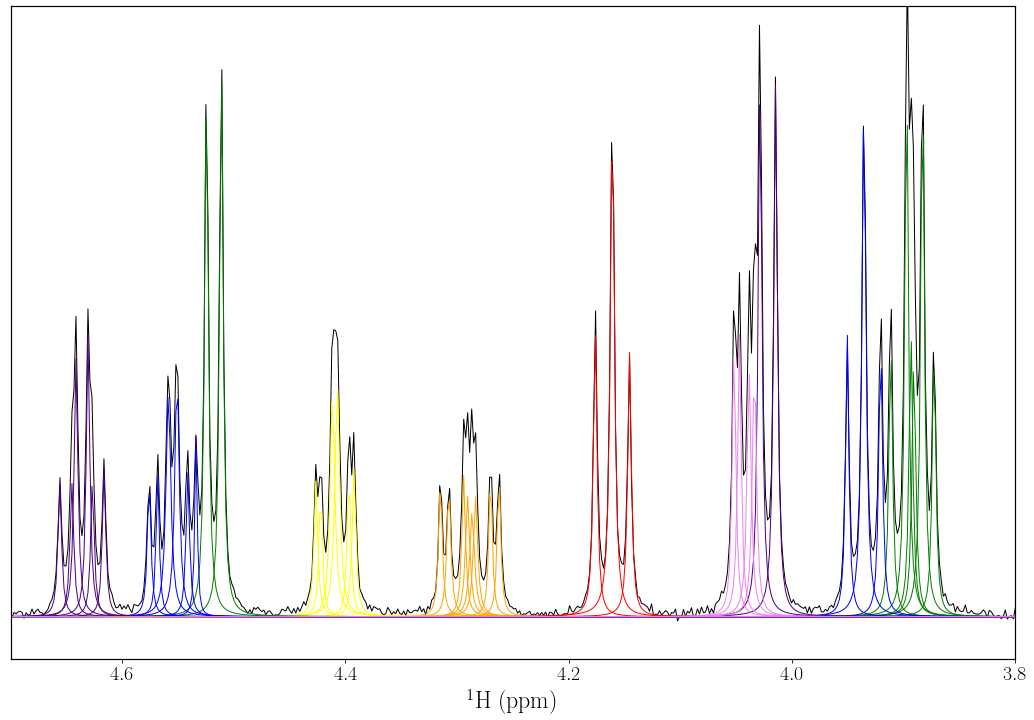

In [6]:
fig = estimator.plot_multiplets(shifts_unit="ppm")

# You could simply save or show the figure at this point
# I'm just doing some hacking below to make the figure look nicer in the notebook
ax = fig.get_axes()[0]
ax.set_xlim(4.7, 3.8)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_xlabel(ax.get_xlabel(), fontdict={"fontsize": 24})
prev_ylim = ax.get_ylim()
ax.set_ylim(prev_ylim[0], 0.55 * prev_ylim[1])

fig.set_size_inches(*[3 * x for x in fig.get_size_inches()])

## Generating a homodecoupled spectrum

The estimation results leaves us in a position to generate a homodecoupled 1D signal, without loss in sensitivity\*

The `Estimator2DJ.negative_45_signal` method creates such a signal. The method is given this name as it generates a signal that mimics what would be derived if one could propagte the 2DJ signal in negative T1, and take the diagonal which bisects the positive T2 and nega T1 axes:

<img src='neg_45_signal.png' width="300" height="400">

\*Typical experimental homodecoupling sequences such as PSYCHE use low flip-angle pulses which lead to a considerable loss in sensitivity.

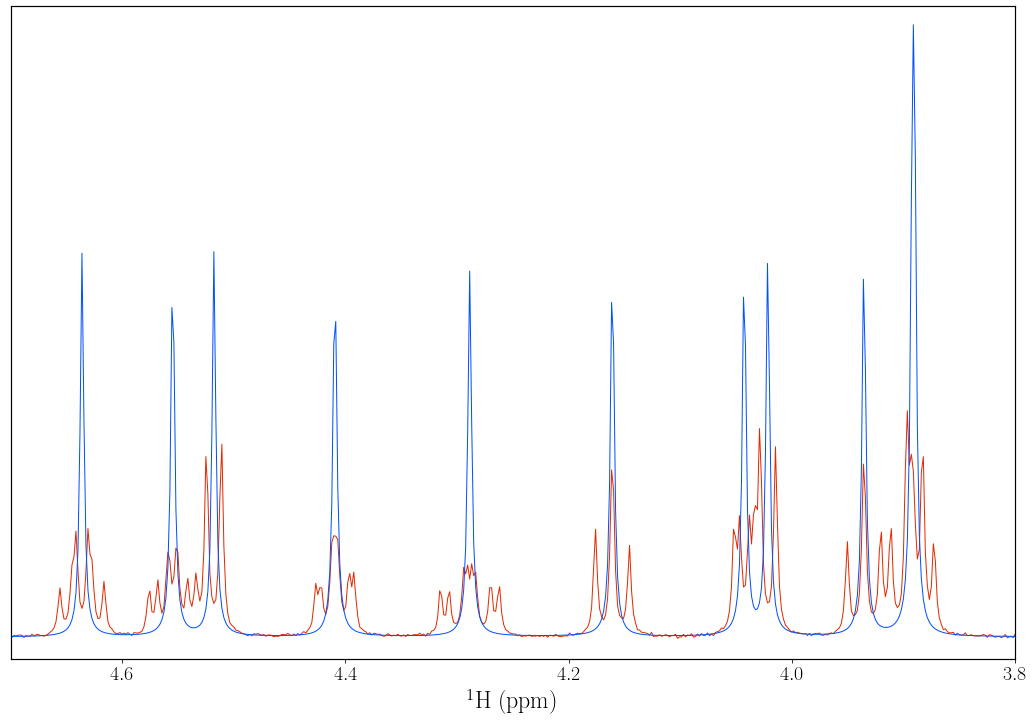

In [7]:
neg_45 = estimator.negative_45_signal()

# There isn't a "plot_homodecoupled" method yet, so a
# figure has to be constructed manually
import matplotlib.pyplot as plt
neg_45[0] *= 0.5
neg_45_spectrum = ne.sig.ft(neg_45).real

spectrum = estimator.spectrum_zero_t1.real
shifts = estimator.get_shifts(meshgrid=False, unit="ppm")[-1]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(shifts, spectrum)
ax.plot(shifts, neg_45_spectrum)
ax.set_xlabel("$^1$H (ppm)")
ax.set_xlim(4.7, 3.8)
ax.set_yticks([])

ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_xlabel(ax.get_xlabel(), fontdict={"fontsize": 24})
fig.set_size_inches(*[3 * x for x in fig.get_size_inches()])

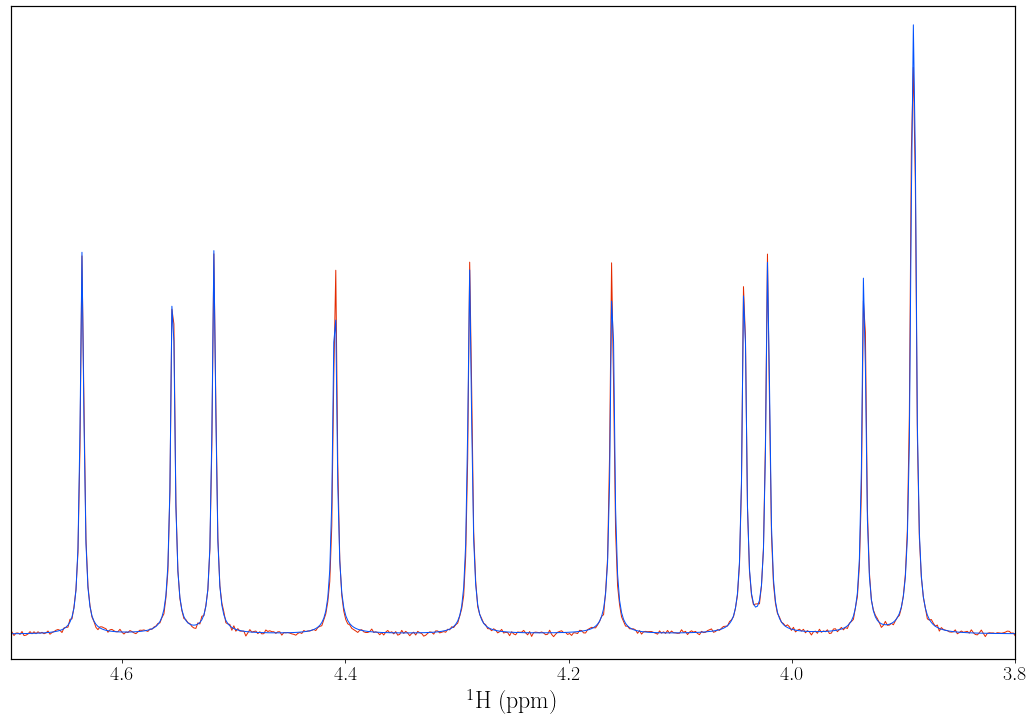

In [8]:
with open("fid_decoupled.pkl", "rb") as fh:
    fid_decoupled = pickle.load(fh)[0]
fid_decoupled[0] *= 0.5
decoupled_spectrum = ne.sig.ft(fid_decoupled).real

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(shifts, decoupled_spectrum)
ax.plot(shifts, neg_45_spectrum)
ax.set_xlabel("$^1$H (ppm)")
ax.set_xlim(4.7, 3.8)
ax.set_yticks([])

ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_xlabel(ax.get_xlabel(), fontdict={"fontsize": 24})
fig.set_size_inches(*[3 * x for x in fig.get_size_inches()])